# Задача 4. Многоклассовая классификация и множественная классификация/регрессия

- [✓] Изучите [возможности sklearn](https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification) для решения задач **Multiclass classification**, **Multilabel classification** и **Multioutput Regression**. Основные компоненты библиотеки указаны на рисунке ниже.
- [✓] Найдите данные, на которых можно решить задачу **Multiclass classification** (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.
- [✓] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.
- [✓] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [✓] Используя стратегии **OneVsRest**, **OneVsOne** и **OutputCode** решите задачу **Multiclass classification** для каждого из пройденных базового алгоритма классификации (**logistic regression, svm, knn, naive bayes, decision tree**). При обучении использовать **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания.
- [✓] Замерить время обучения каждой модели для каждой стратегии.
- [✓] Для оценки качества моделей используйте метрику **AUC-ROC**.
- [✓] Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.

**Выполнил:** Пушкин Т.Д., группа 471 (20.Б11-мм)

In [205]:
import statistics as stat
import time
from pathlib import Path
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, MetaEstimatorMixin
from sklearn.compose import make_column_transformer
from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

## Датасет

Воспользуемся датасетом для определения типа лесного покрова по картографическим данным из национального леса Рузвельт северной части штата Колорадо, США из scikit-learn.

Каждое наблюдение описывает регион 30 на 30 метров и состоит из следующих признаков:
- Elevation --- высота над уровнем моря (метры)
- Aspect --- направление уклона земной поверхности (градусы азимута)
- Slope --- величина уклон земной поверхности (градусы)
- Horizontal_Distance_To_Hydrology --- горизонтальное расстояние до ближайшей водной поверхности (метры)
- Vertical_Distance_To_Hydrology --- горизонтальное расстояние до ближайшей водной поверхности (метры)
- Horizontal_Distance_To_Roadways --- горизонтальное расстояние до ближайшей дороги (метры)
- Hillshade_9am --- индекс отмывки рельефа в 9 утра в день летнего солнцестояния (0--255)
- Hillshade_Noon --- индекс отмывки рельефа в полдень в день летнего солнцестояния (0--255)
- Hillshade_3pm --- индекс отмывки рельефа в 3 часа дня в день летнего солнцестояния (0--255)
- Horizontal_Distance_To_Fire_Points --- горизонтальное расстояние до ближайшей точки возникновения лесного пожара (метры)
- Wilderness_Area (4 бинарных признака) --- принадлежность к одной из четырёх «Территорий дикой природы», в которых проводились наблюдения (0 --- Рава, 1 --- Неота, 2 --- Команчи-Пик, 3 --- Кэш-ла-Пудр)
- Soil_Type (40 бинарных признаков) --- тип почвы (0--39)
- Cover_Type --- вид лесного покрова (1--7)

Оригинальный датасет содержит более полумиллиона записей, из-за чего некоторые модели учатся на нём слишком долго. Возьмём из него случайные 50 тысяч наблюдений.

In [206]:
df = fetch_covtype(as_frame=True, random_state=1, shuffle=True).frame.head(50000)
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2949.0,101.0,21.0,693.0,151.0,3009.0,250.0,206.0,74.0,595.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,3198.0,156.0,10.0,510.0,23.0,3900.0,232.0,241.0,140.0,4221.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2199.0,2.0,18.0,323.0,78.0,540.0,193.0,204.0,147.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,2851.0,111.0,14.0,150.0,27.0,2394.0,243.0,224.0,107.0,2290.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2920.0,47.0,21.0,335.0,119.0,2292.0,222.0,189.0,92.0,2059.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Elevation                           50000 non-null  float64
 1   Aspect                              50000 non-null  float64
 2   Slope                               50000 non-null  float64
 3   Horizontal_Distance_To_Hydrology    50000 non-null  float64
 4   Vertical_Distance_To_Hydrology      50000 non-null  float64
 5   Horizontal_Distance_To_Roadways     50000 non-null  float64
 6   Hillshade_9am                       50000 non-null  float64
 7   Hillshade_Noon                      50000 non-null  float64
 8   Hillshade_3pm                       50000 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  50000 non-null  float64
 10  Wilderness_Area_0                   50000 non-null  float64
 11  Wilderness_Area_1                   50000

In [208]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000
mean,2959.748260,156.113940,14.086320,269.699200,45.993880,2355.898780,212.120160,223.289360,142.545440,1974.718780,...,0.090880,0.076240,0.00312,0.003180,0.000160,0.000400,0.026660,0.024140,0.01518,2.047500
std,279.750595,112.041955,7.474374,212.553251,58.014142,1565.028789,26.780514,19.784024,38.147861,1326.092152,...,0.287441,0.265384,0.05577,0.056302,0.012648,0.019996,0.161089,0.153485,0.12227,1.396439
min,1863.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
25%,2810.000000,59.000000,9.000000,108.000000,7.000000,1110.000000,198.000000,213.000000,119.000000,1020.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,2997.000000,128.000000,13.000000,218.000000,29.000000,1998.000000,218.000000,226.000000,143.000000,1706.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000
75%,3165.000000,261.000000,18.000000,384.000000,68.000000,3330.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000
max,3845.000000,360.000000,64.000000,1371.000000,574.000000,7117.000000,254.000000,254.000000,254.000000,7091.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,7.000000


В датасете нет пропущенных значений, а категориальные признаки (кроме целевого) уже one-hot-закодированы.

## Разведочный анализ (EDA) и преобразование данных

Для удобства анализа сгруппируем one-hot-закодированные колонки.

In [209]:
wilderness_areas_labeled = df.filter(like="Wilderness_Area").idxmax(axis="columns").apply(
    lambda s: int(s.removeprefix("Wilderness_Area_")))
soil_type_labels = df.filter(like="Soil_Type").idxmax(axis="columns").apply(lambda s: int(s.removeprefix("Soil_Type_")))

df_eda = df.drop(columns=df.filter(regex="(Wilderness_Area_.*)|(Soil_Type.*)").columns).assign(
    Wilderness_Area=wilderness_areas_labeled, Soil_Type=soil_type_labels
)
df_eda

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type
0,2949.0,101.0,21.0,693.0,151.0,3009.0,250.0,206.0,74.0,595.0,2,2,9
1,3198.0,156.0,10.0,510.0,23.0,3900.0,232.0,241.0,140.0,4221.0,1,0,28
2,2199.0,2.0,18.0,323.0,78.0,540.0,193.0,204.0,147.0,150.0,6,3,9
3,2851.0,111.0,14.0,150.0,27.0,2394.0,243.0,224.0,107.0,2290.0,2,0,28
4,2920.0,47.0,21.0,335.0,119.0,2292.0,222.0,189.0,92.0,2059.0,1,2,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2729.0,6.0,7.0,277.0,29.0,2110.0,211.0,226.0,152.0,6155.0,2,0,11
49996,3313.0,155.0,16.0,30.0,-3.0,2036.0,237.0,240.0,128.0,900.0,7,2,21
49997,2807.0,74.0,23.0,120.0,28.0,3210.0,240.0,191.0,70.0,726.0,2,2,9
49998,2709.0,55.0,15.0,509.0,45.0,3157.0,228.0,207.0,108.0,2799.0,1,2,9


Для начала рассмотрим распределения по категориальным признакам.

Заметим, что оно крайне неравномерное. В частности, из-за неравномерного распределения по целевому признаку `Cover_Type` при разделении датасета на части важно будет применять стратификацию по данному признаку.

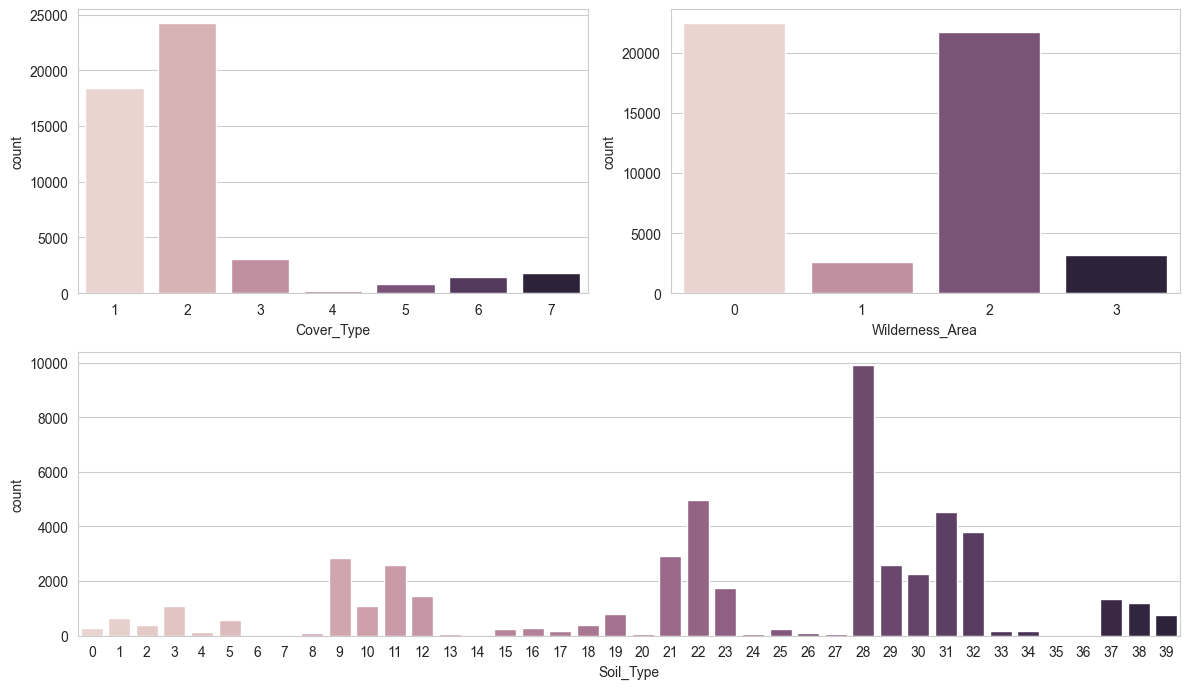

In [210]:
fig = plt.figure(figsize=(12, 7), tight_layout=True)
gs = fig.add_gridspec(2, 2)
sns.countplot(df_eda, x="Cover_Type", hue="Cover_Type", legend=None, ax=fig.add_subplot(gs[0, 0]))
sns.countplot(df_eda, x="Wilderness_Area", hue="Wilderness_Area", legend=None, ax=fig.add_subplot(gs[0, 1]))
sns.countplot(df_eda, x="Soil_Type", hue="Soil_Type", legend=None, ax=fig.add_subplot(gs[1, :]));

У многих некатегориальных признаков распределение сильно ассиметрично, присутствует большое число значений, удалённых от "пика" плотности --- при масштабировании данных хорошей идеей будет использовать `RobustScaler` вместо `StandardScaler`.

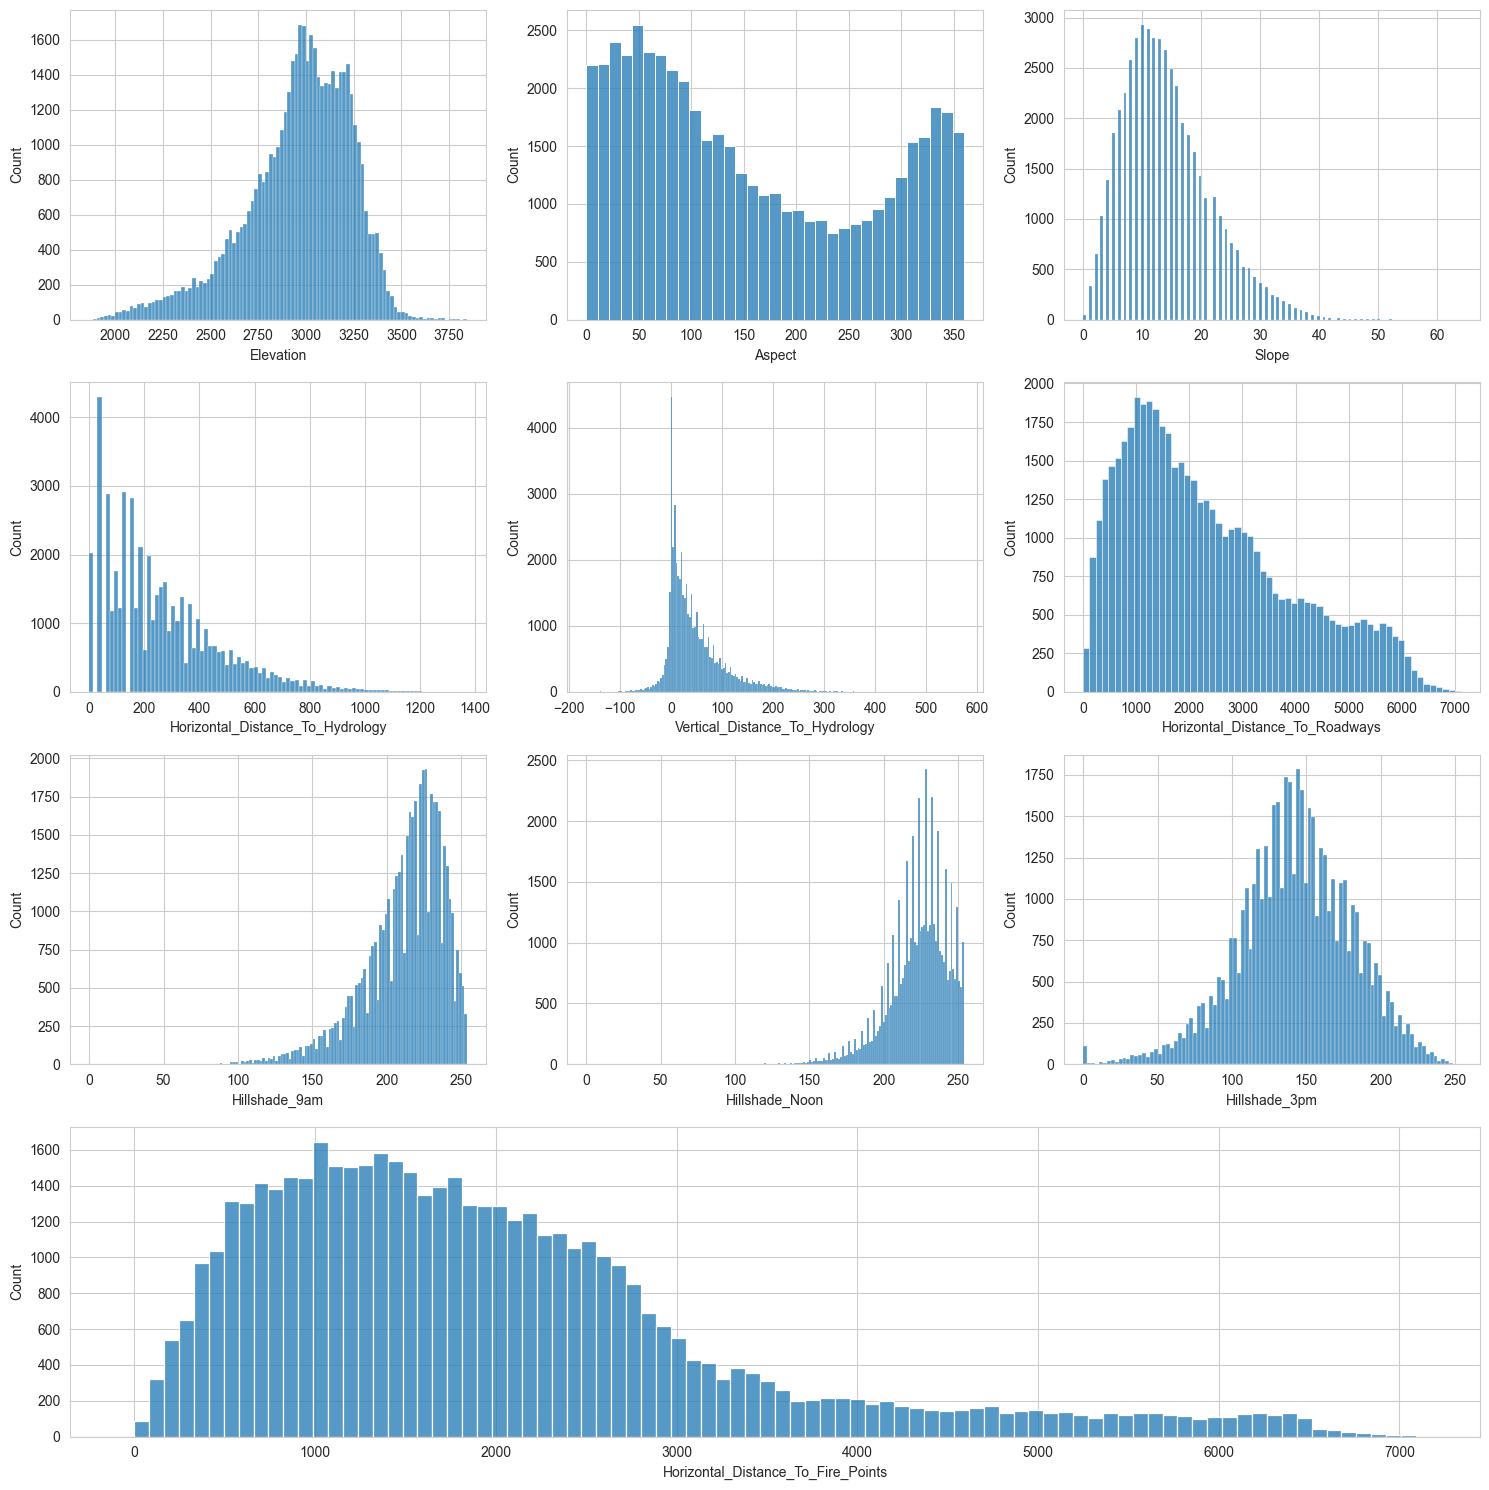

In [211]:
fig = plt.figure(figsize=(15, 15), tight_layout=True)
gs = fig.add_gridspec(4, 3)
for i in range(3):
    for j in range(3):
        sns.histplot(df_eda[df_eda.columns[3 * i + j]], ax=fig.add_subplot(gs[i, j]))
sns.histplot(df_eda[df_eda.columns[9]], ax=fig.add_subplot(gs[3, :]));

Вручную приобразуем признак `Aspect`, чтобы получить распределение, более походящее на нормальное: "сдвинем" его на 120 градусов.

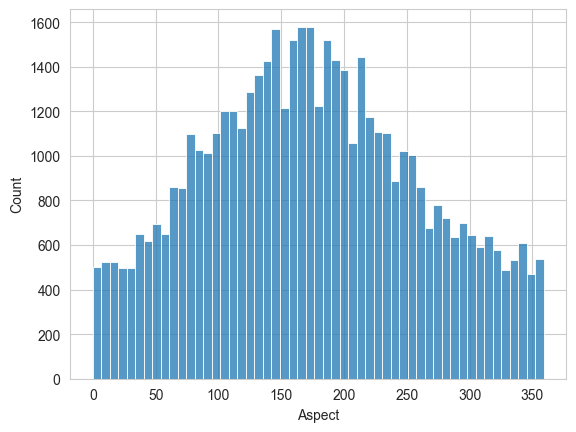

In [212]:
df_eda["Aspect"] = df["Aspect"] = (df["Aspect"] + 120) % 360
sns.histplot(df_eda["Aspect"]);

Слишком большой взаимной зависимости между количественными признаками не наблюдается. Разве что между `Hillshade_9am` и `Hillshade_3pm` относительно высокая отрицательная корреляция, но это достаточно ожидаемо для холмистой местности (если поверхность находится на западной или восточной стороне холма, то полдня она будет освещена солнцем, а полдня --- нет).

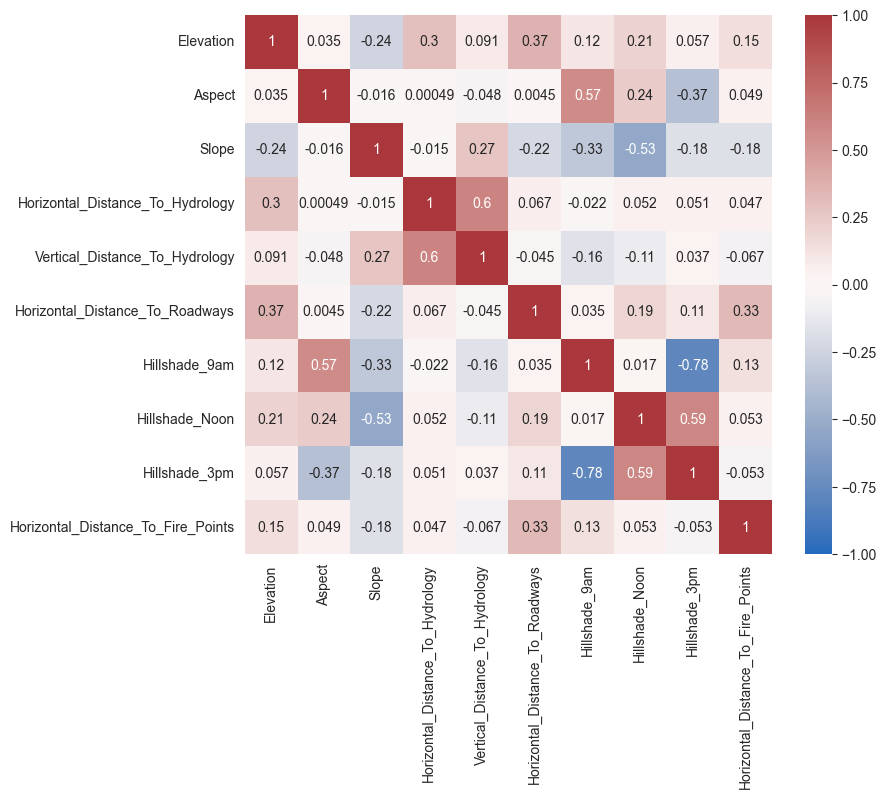

In [213]:
plt.figure(figsize=(8.5, 7))
sns.heatmap(df_eda.drop(columns=["Wilderness_Area", "Soil_Type", "Cover_Type"]).corr(), vmin=-1, vmax=1, annot=True,
            cmap="vlag");

In [214]:
# Больше не потребуется
del df_eda

# Далее удобнее работать с разделёнными нецелевыми и целевым признаками
X, y = df.drop(columns="Cover_Type"), df["Cover_Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42, stratify=y)

## Обучение

Для подбора гипер-параметров будем использовать F1-метрику с macro-усреднением (так как распределение по классам крайне неравномерное).

При финальном тестировании будем подсчитывать AUC-ROC со стратегией подсчёта one-vs-one и macro-усреднением (согласно документации scikit-learn, именно эта комбинация наилучшим образом подходит для неравномерного распределения по классам). Стоит отметить, что в scikit-learn AUC-ROC требует от модели результат в вероятностном формате (вероятность принадлежности элемента выборки к каждому классу) --- "из коробки" такой формат предоставляет лишь реализация стратегии one-vs-rest (да и то не для всех классификаторов), для остальных же нечто, обладающее свойствами вероятности (сумма "вероятностей" должна равняться единице), пришлось реализовать самостоятельно.

Время обучения подсчитывается один раз, так как оно, как правило, достаточно велико, а время получения результата не тестовых данных --- десять раз для последующего усреднения.

In [215]:
def make_pipeline(estimator):
    quantitative_columns = X.drop(columns=X.filter(regex="(Wilderness_Area_.*)|(Soil_Type.*)").columns).columns
    transformer = make_column_transformer((RobustScaler(), quantitative_columns), remainder="passthrough")
    return Pipeline([("transformer", transformer), ("estimator", estimator)])


def train_metaestimator(metaestimator: MetaEstimatorMixin, param_grid: dict, predict_proba: Callable):
    pipeline = make_pipeline(metaestimator)
    param_grid = {f"estimator__estimator__{name}": val for name, val in param_grid.items()}

    cv = GridSearchCV(
        pipeline,
        param_grid,
        scoring="f1_macro",
        n_jobs=6,
    )
    cv.fit(X_train, y_train)

    print(
        metaestimator.estimator.__class__.__name__.removesuffix("Classifier"),
        " - ",
        metaestimator.__class__.__name__.removesuffix("Classifier")
    )
    print(
        "Best params:",
        {name.removeprefix("estimator__estimator__"): val for name, val in cv.best_params_.items()}
    )

    auc_roc = roc_auc_score(y_test, predict_proba(cv.best_estimator_, X_test), multi_class='ovo')
    print()
    print(f"Mean train F1: {cv.best_score_:.5f}")
    print(f"Test AUC-ROC: {auc_roc:.5f}")

    pred_times = []
    for i in range(10):
        start = time.perf_counter_ns()
        cv.best_estimator_.predict(X_test)
        finish = time.perf_counter_ns()
        pred_times.append((finish - start) * 1e-6)
    print()
    print(f"Fit time: {cv.refit_time_:.2f} s")
    print(f"Predict time: {stat.mean(pred_times):.2f} ± {stat.stdev(pred_times):.2f} ms")

    results = []
    for pred_time in pred_times:
        results.append({
            "Model": metaestimator.estimator.__class__.__name__.removesuffix("Classifier"),
            "Strategy": metaestimator.__class__.__name__.removesuffix("Classifier"),
            "Train F1": cv.best_score_,
            "Test AUC-ROC": auc_roc,
            "Fit time, s": cv.refit_time_,
            "Predict time, ms": pred_time
        })

    results_path = Path("results.csv")
    if results_path.exists():
        pd.DataFrame(results).to_csv("results.csv", index=False, header=False, mode="a")
    else:
        pd.DataFrame(results).to_csv("results.csv", index=False)


def l1_normalize_rows(a: npt.ArrayLike) -> npt.NDArray:
    """ Позволяет получить подобие вероятностей (матрицу, значения которой построчно суммируются к единице) для ROC-AUC из scikit-learn. """
    row_sums = np.sum(a, axis=1)
    return a / row_sums[:, np.newaxis]


def predict_proba_ovr(pipelined_ovr: Pipeline, X: npt.ArrayLike) -> npt.NDArray:
    """ Получение "вероятностного" результата для стратегии one-vs-rest. """
    if hasattr(pipelined_ovr, "predict_proba"):
        pred = pipelined_ovr.predict_proba(X)
        if isinstance(pipelined_ovr.named_steps["estimator"].estimator, DecisionTreeClassifier):
            # Для DecisionTreeClassifier OneVsRestClassifier.predict_proba() возвращает строку NaN-ов,
            # когда считает, что вероятность принадлежности элемента ко всем классам равна 0 (кажется,
            # что такого происходить не должно, но оно происходит). Будем считать, что в этом случае
            # вероятность принадлежности ко всем классам равна.
            pred = np.nan_to_num(pred, nan=1 / pred.shape[1])
        return pred

    # OneVsRestClassifier.decision_function() возвращает расстояния, а чем меньше расстояние,
    # тем больше вероятность, поэтому нормализуем значения, обратные расстоянию
    pred_dists = pipelined_ovr.decision_function(X)
    return l1_normalize_rows(np.divide(1, pred_dists, where=pred_dists != 0))


def predict_proba_ovo(pipelined_ovo: Pipeline, X: npt.ArrayLike) -> npt.NDArray:
    """ Получение "вероятностного" результата для стратегии one-vs-one. """
    y_pred = pipelined_ovo.decision_function(X)
    return l1_normalize_rows(y_pred)


def predict_proba_oc(pipelined_oc: Pipeline, X: npt.ArrayLike) -> npt.NDArray:
    """ Получение "вероятностного" результата для стратегии output code. """
    # OutputCodeClassifier не предоставляет нужного интерфейса, поэтому здесь повторена реализация OutputCodeClassifier.predict()
    from sklearn.multiclass import _predict_binary
    from sklearn.metrics.pairwise import pairwise_distances

    transformer = pipelined_oc.named_steps["transformer"]
    X = transformer.transform(X)

    oc: OutputCodeClassifier = pipelined_oc.named_steps["estimator"]
    Y = np.array(
        [_predict_binary(e, X) for e in oc.estimators_],
        order="F",
        dtype=np.float64,
    ).T
    pred_dists = pairwise_distances(Y, oc.code_book_)
    # Чем меньше расстояние, тем больше вероятность, поэтому нормализуем значения, обратные расстоянию
    return l1_normalize_rows(np.divide(1, pred_dists, where=pred_dists != 0))


def train(estimator: BaseEstimator, param_grid: dict):
    train_metaestimator(OneVsRestClassifier(estimator, n_jobs=2), param_grid, predict_proba=predict_proba_ovr)
    print("\n============\n\n")
    train_metaestimator(OneVsOneClassifier(estimator, n_jobs=2), param_grid, predict_proba=predict_proba_ovo)
    print("\n============\n\n")
    train_metaestimator(OutputCodeClassifier(estimator, n_jobs=2, random_state=42), param_grid,predict_proba=predict_proba_oc)

In [216]:
train(
    LogisticRegression(n_jobs=2, random_state=42),
    {
        "tol": [1e-5, 1e-4],
        "C": [0.5, 1, 2]
    }
)

LogisticRegression  -  OneVsRest
Best params: {'C': 2, 'tol': 1e-05}

Mean train F1: 0.46066
Test AUC-ROC: 0.91597

Fit time: 2.03 s
Predict time: 3.88 ± 0.11 ms


LogisticRegression  -  OneVsOne
Best params: {'C': 2, 'tol': 1e-05}

Mean train F1: 0.52051
Test AUC-ROC: 0.92770

Fit time: 1.85 s
Predict time: 13.96 ± 0.37 ms


LogisticRegression  -  OutputCode
Best params: {'C': 2, 'tol': 1e-05}

Mean train F1: 0.43864
Test AUC-ROC: 0.79880

Fit time: 2.38 s
Predict time: 5.28 ± 1.15 ms


In [218]:
train(
    KNeighborsClassifier(n_jobs=2),
    {"n_neighbors": [3, 5, 7]}
)

KNeighbors  -  OneVsRest
Best params: {'n_neighbors': 3}

Mean train F1: 0.71260
Test AUC-ROC: 0.93182

Fit time: 1.07 s
Predict time: 1276.60 ± 17.41 ms


KNeighbors  -  OneVsOne
Best params: {'n_neighbors': 3}

Mean train F1: 0.71679
Test AUC-ROC: 0.96152

Fit time: 1.10 s
Predict time: 4544.24 ± 150.79 ms


KNeighbors  -  OutputCode
Best params: {'n_neighbors': 3}

Mean train F1: 0.71253
Test AUC-ROC: 0.92715

Fit time: 1.14 s
Predict time: 1639.31 ± 28.60 ms


Общая реализация SVM из scikit-learn, называемая `SVC`, обучается чрезвычайно долго, поэтому было принято решение использовать лишь более быструю линейную реализацию --- `LinearSVC`.

In [219]:
train(
    LinearSVC(random_state=42),
    {
        "tol": [1e-5, 1e-4],
        "C": [0.5, 1, 2]
    },
)

LinearSVC  -  OneVsRest
Best params: {'C': 2, 'tol': 0.0001}

Mean train F1: 0.44446
Test AUC-ROC: 0.56409

Fit time: 3.68 s
Predict time: 4.05 ± 0.19 ms


LinearSVC  -  OneVsOne
Best params: {'C': 2, 'tol': 1e-05}

Mean train F1: 0.51877
Test AUC-ROC: 0.93191

Fit time: 2.44 s
Predict time: 14.69 ± 1.33 ms


LinearSVC  -  OutputCode
Best params: {'C': 2, 'tol': 1e-05}

Mean train F1: 0.42668
Test AUC-ROC: 0.80722

Fit time: 5.93 s
Predict time: 4.99 ± 0.41 ms


Так как признаки имеют более-менее нормальное распределение, используем гауссовский Naive Bayes.

In [220]:
train(
    GaussianNB(),
    {"var_smoothing": [1e-9, 1e-8, 1e-5, 1e-3]},
)

GaussianNB  -  OneVsRest
Best params: {'var_smoothing': 0.001}

Mean train F1: 0.31659
Test AUC-ROC: 0.85202

Fit time: 0.96 s
Predict time: 23.15 ± 0.84 ms


GaussianNB  -  OneVsOne
Best params: {'var_smoothing': 0.001}

Mean train F1: 0.33531
Test AUC-ROC: 0.88591

Fit time: 1.00 s
Predict time: 129.38 ± 36.41 ms


GaussianNB  -  OutputCode
Best params: {'var_smoothing': 0.001}

Mean train F1: 0.23125
Test AUC-ROC: 0.77100

Fit time: 1.03 s
Predict time: 27.81 ± 1.17 ms


In [221]:
train(
    DecisionTreeClassifier(random_state=42),
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_leaf_nodes": [None, 50, 100, 500],
    },
)

DecisionTree  -  OneVsRest
Best params: {'criterion': 'entropy', 'max_leaf_nodes': 500, 'splitter': 'random'}

Mean train F1: 0.71806
Test AUC-ROC: 0.92265

Fit time: 1.22 s
Predict time: 7.03 ± 0.13 ms



E:\Projects\courses\ml-course\venv\Lib\site-packages\sklearn\multiclass.py:503: RuntimeWarning: invalid value encountered in divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


DecisionTree  -  OneVsOne
Best params: {'criterion': 'entropy', 'max_leaf_nodes': None, 'splitter': 'best'}

Mean train F1: 0.72873
Test AUC-ROC: 0.95834

Fit time: 1.65 s
Predict time: 28.80 ± 2.64 ms


DecisionTree  -  OutputCode
Best params: {'criterion': 'entropy', 'max_leaf_nodes': None, 'splitter': 'random'}

Mean train F1: 0.70481
Test AUC-ROC: 0.93635

Fit time: 1.39 s
Predict time: 10.83 ± 0.23 ms


## Сравнение моделей и выводы

В ходе обучения и тестирования были получены следующие результаты:

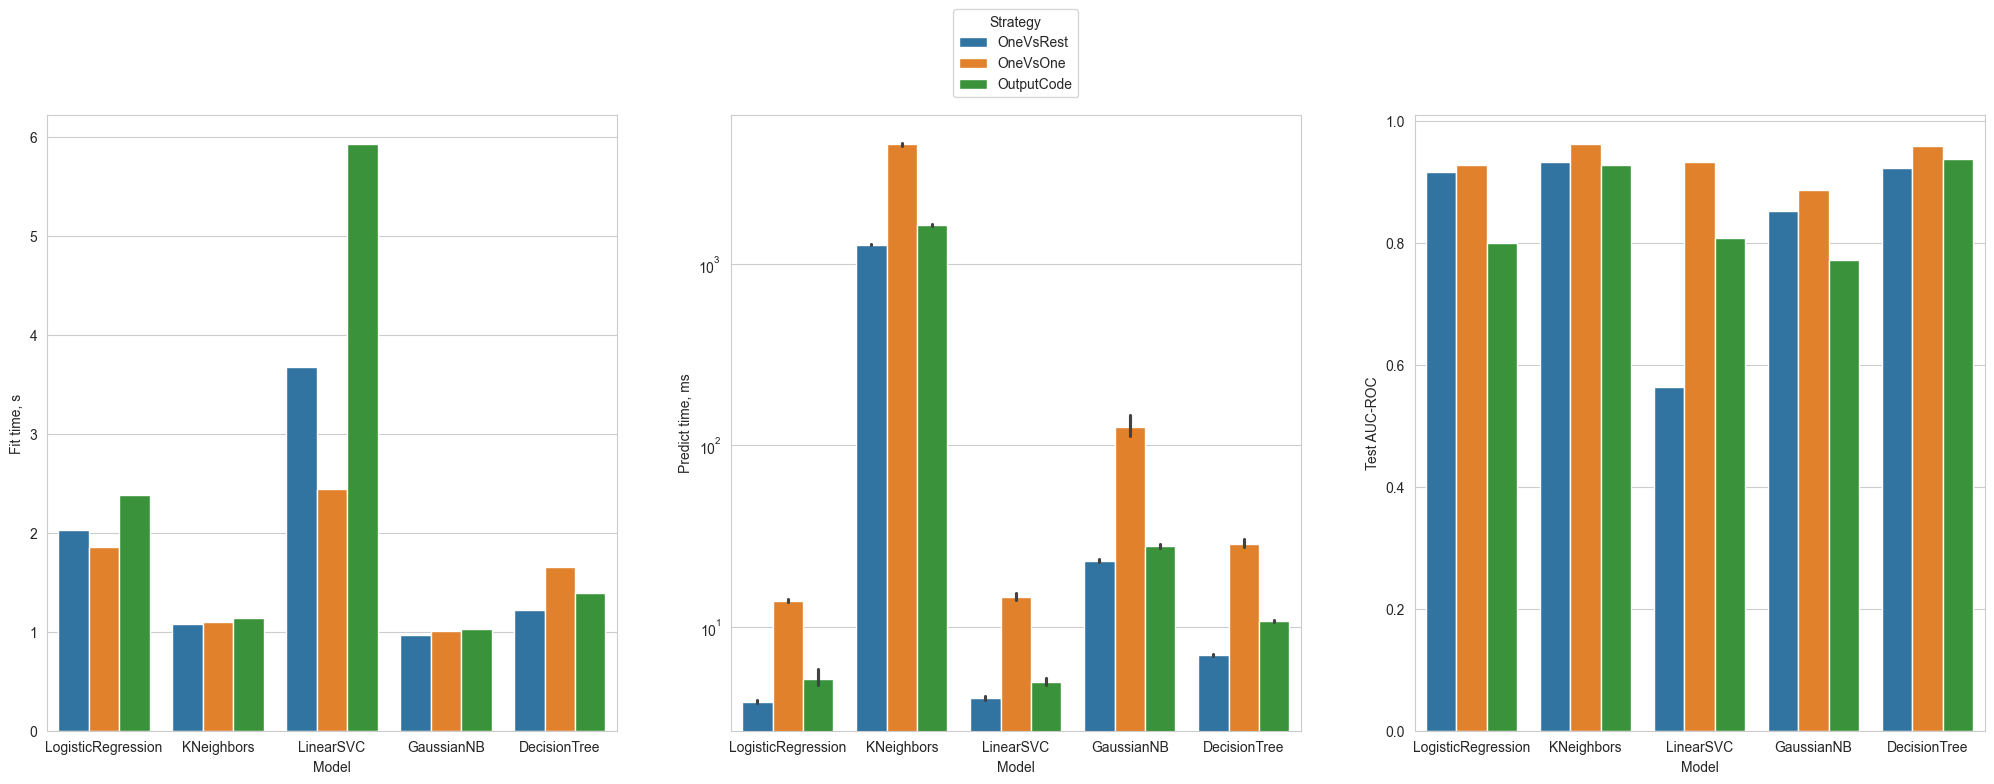

In [244]:
results = pd.read_csv("results.csv")

fig, axs = plt.subplots(ncols=3, figsize=(25, 8))
sns.barplot(results, x="Model", y="Fit time, s", hue="Strategy", legend=False, ax=axs[0])
axs[1].set_yscale("log") # log_scale из seaborn работает странно
sns.barplot(results, x="Model", y="Predict time, ms", hue="Strategy", ax=axs[1])
sns.move_legend(axs[1], "center", bbox_to_anchor=(0.5, 1.1))
sns.barplot(results, x="Model", y="Test AUC-ROC", hue="Strategy", legend=False, ax=axs[2]);

Из них можно сделать следующие выводы относительно стратегий многоклассовой классификации:
1. По скорости обучения стратегии one-vs-rest и one-vs-one в большинстве случаев оказываются быстрее output code, но между one-vs-rest и one-vs-one однозначно более быструю по обучению стратегию выбрать не удаётся. Это не вполне ожидаемый результат, так как one-vs-rest обучает 7 классификаторов, one-vs-one --- 21, а output code --- 10 (параметр `code_size`, определяющий количество подготавливаемых классификаторов, был равен 1.5).
2. По скорости работы для всех моделей самой быстрой стратегией является one-vs-rest, на втором месте с небольшим отрывом --- output code, на третьем с отрывом на несколько порядков --- one-vs-one. Такой результат уже вполне ожидаем, исходя из количества классификаторов, используемых данными стратегиями.
3. По качеству работы, исходя из метрики AUC-ROC, наилучшей стратегией для всех моделей является one-vs-one, а лидер между one-vs-rest и output code сменяется от модели к модели.

Из них можно сделать следующие выводы относительно использованных моделей:
1. Логистическая регрессия обучается дольше большинства моделей, однако затем быстро отрабатывает и показывает достаточно хорошие результаты.
2. KNN обучается очень быстро и позволяет достичь наилучших результатов, однако и работает в сотни-тысячи раз медленнее остальных моделей.
3. Линейная SVM обучается медленнее всех, но работает крайне быстро. При этом, если не применять стратегию one-vs-rest, которая приводит к наихудшим результатам, качетво модели получаются примерно тем же, что и у линейной регрессии.
4. Гауссовский Naive Bayes обучается быстрее всех, но при этом работает сравнительно медленно и результаты получаются хуже, чем у большинства остальных моделей с любой стратегией.
5. Решающее дерево находится посередине по скорости обучения и работы, однако позволяет достичь почти самых лучших результатов, уступая лишь KNN.

В целом на данном датасете наилучший результат по скорости и качеству (метрике AUC-ROC) показывает решающее дерево со стратегией многоклассовой классификации output code.